In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from imblearn.under_sampling import RandomUnderSampler

import xgboost

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score

import optuna

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme()

import wandb
from wandb.keras import WandbCallback

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print(f'Train size: {len(train)}')
print(f'Train ids: {len(train.id.unique())}')
print(f'Test size: {len(test.id.unique())}')
print(f'Test ids: {len(test)}')

Train size: 60487
Train ids: 229
Test size: 46
Test ids: 15034


In [4]:
train.head()

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0


## Data analyzing and preparation

In [5]:
train.isna().mean(axis=0)

id      0.0
time    0.0
x       0.0
y       0.0
dtype: float64

<AxesSubplot:xlabel='x'>

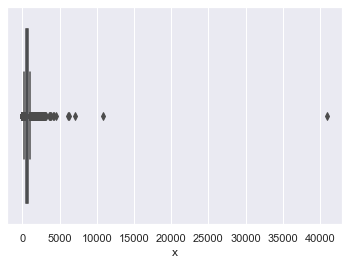

In [7]:
sns.boxplot(x=train.x)

<AxesSubplot:xlabel='x'>

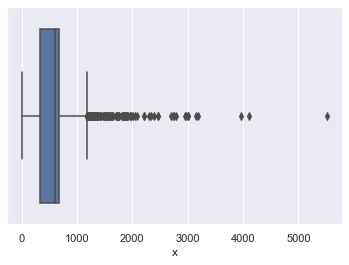

In [32]:
sns.boxplot(x=test.x)

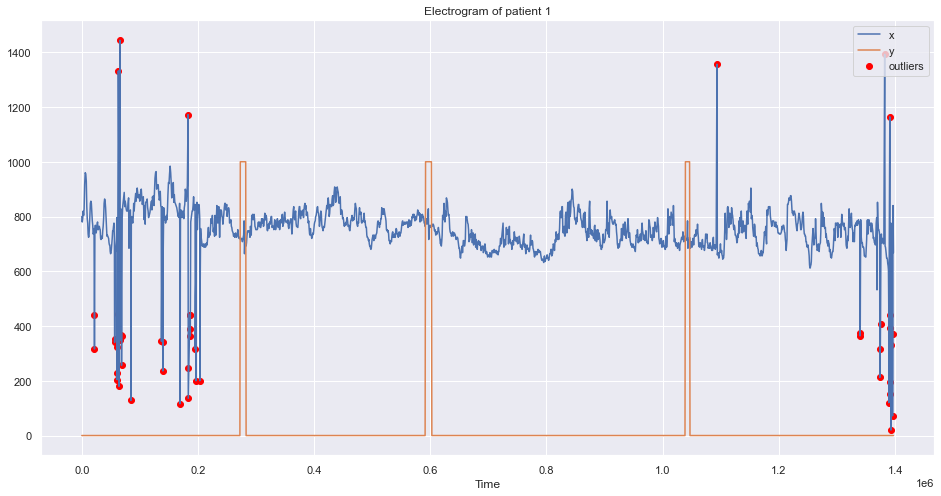

In [49]:
data_slice = train[train.id == 1]
z = np.abs(stats.zscore(data_slice.x))
outliers = data_slice.iloc[np.where(z > 3)[0]]
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(data_slice.time, data_slice.x, label='x')
ax.plot(data_slice.time, data_slice.y * 1000, label='y')
ax.scatter(outliers.time, outliers.x, label='outliers', color='red')
ax.legend(loc='upper right')
plt.xlabel('Time')
plt.title('Electrogram of patient 1')
plt.show()

#### Conclusion: outliers are not connected with spikes regions - so we can simply remove them

In [43]:
def remove_outliers(df, column, z_threshold=3):
    z = np.abs(stats.zscore(df[column]))
    outliers = np.where(z > z_threshold)[0]
    
    return df.drop(outliers)

<AxesSubplot:xlabel='x'>

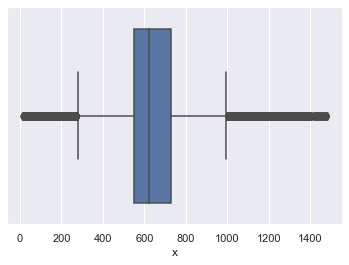

In [44]:
sns.boxplot(x=remove_outliers(train, 'x').x)

<AxesSubplot:xlabel='x'>

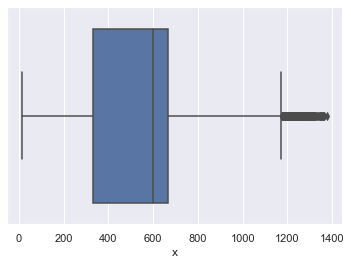

In [45]:
sns.boxplot(x=remove_outliers(test, 'x').x)

In [46]:
train = remove_outliers(train, 'x')
test = remove_outliers(test, 'x')

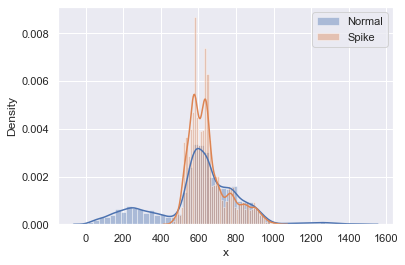

In [47]:
sns.distplot(train[train.y == 0].x, label='Normal');
sns.distplot(train[train.y == 1].x, label='Spike');
plt.legend(loc='upper right');

In [7]:
def find_spikes_regions(df):
    spikes_regions = []
    start = 0
    for i in range(0, len(df)-1):
        if df.iloc[i].y == 0 and df.iloc[i+1].y == 1:
            start = i
        elif df.iloc[i].y == 1 and df.iloc[i+1].y == 0:
            end = i
            spikes_regions.append([start, end])
    return spikes_regions

In [8]:
spikes = find_spikes_regions(data_slice)
spikes

[[352, 366], [757, 771], [1373, 1384]]

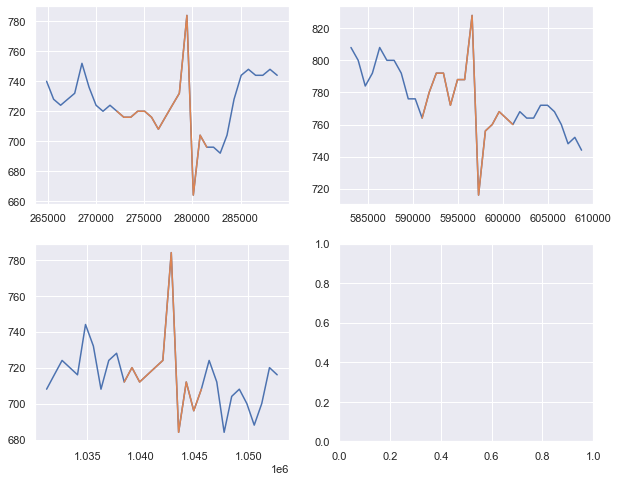

In [9]:
window_width = 10
ncols = 2
extra_row = 0 if len(spikes)%ncols == 0 else 1
nrows = len(spikes)//ncols + extra_row
fig, axs = plt.subplots(nrows, ncols, figsize=(10,8))
axs = axs.flatten()
for i in range(len(spikes)):
    ax = axs[i]
    start = spikes[i][0]
    end = spikes[i][1]
    window = data_slice.iloc[start-window_width: end+window_width]
    ax.plot(window.time, window.x)
    spike = data_slice.iloc[start: end]
    ax.plot(spike.time, spike.x)

#### Conclusion: spikes have a characteristic pattern - zigzag.

In [10]:
spikes = {}
for i in train.id.unique():
    data_slice = train[train.id == i]
    spikes[i] = find_spikes_regions(data_slice)

In [11]:
lengths = np.array([])
for spikes_regions in spikes.values():
    for spike in spikes_regions:
        lengths = np.append(lengths, spike[1] - spike[0])
print('Mean spike region length: ', lengths.mean())

Mean spike region length:  11.331645569620253


#### Conclusion: mean region length is 11, so take frame length as 10

In [12]:
frame_len = 10

## Data preparation

In [13]:
scaler = StandardScaler()

In [14]:
scaler.fit(train.x.values.reshape(-1, 1))

StandardScaler()

In [15]:
train.x = scaler.transform(train.x.values.reshape(-1, 1))[:, 0]
test.x = scaler.transform(test.x.values.reshape(-1, 1))[:, 0]

In [16]:
def create_frames(df, frame_len=10, offset=0, spike_threshold=7):
    X, y = [], []
    
    for i in df.id.unique():
        data_slice = df[df.id == i]
        for n in range((len(data_slice)-offset)//frame_len):
            frame = data_slice.iloc[n*frame_len+offset:(n+1)*frame_len+offset]
            spike = 1 if sum(frame.y) >= spike_threshold else 0
            X.append(frame.x.values.tolist())
            y.append(spike)
                
    return np.expand_dims(np.array(X), axis=2), np.expand_dims(np.array(y), axis=1)

In [17]:
X_train, y_train = create_frames(train)
X_test, y_test = create_frames(test)

In [18]:
print(f'Train spike number: {y_train.sum()}')
print(f'Test spike number: {y_test.sum()}')
print(f'Train class balance: {y_train.sum()/len(y_train)}')
print(f'Test class balance: {y_test.sum()/len(y_test)}')

Train spike number: 680
Test spike number: 123
Train class balance: 0.11428571428571428
Test class balance: 0.08282828282828283


## CNN model

In [19]:
def create_model(conv_layers, dense_layers, kernel_size, pool_size, frame_len, layer_size=128, lr=0.001, dropout=0.0):
    model = Sequential()
    
    for c in range(conv_layers):
        model.add(layers.Conv1D(layer_size, kernel_size, activation='relu', input_shape=(frame_len, 1)))
        model.add(layers.MaxPooling1D(pool_size=pool_size))
        
    model.add(layers.Flatten())
    
    for d in range(dense_layers):
        model.add(layers.Dense(layer_size, activation = 'relu'))
        if dropout:
            model.add(layers.Dropout(dropout))
            
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss=['binary_crossentropy'], metrics=[BinaryAccuracy()])
    
    return model

In [20]:
model = create_model(2, 2, 3, 2, frame_len=frame_len)

In [ ]:
run = wandb.init(project='covid_cardiospike_detection', name='cnn')

In [ ]:
wandb_callback = WandbCallback(monitor='loss', log_weights=True)

In [23]:
def restore_prediction(test, pred):
    pred_restored = np.array([])
    n = 0

    for i in test.id.unique():
        slice_len = len(test[test.id == i])
        full_len = slice_len//frame_len
        last_len = slice_len%frame_len

        for k in range(n, n+full_len):
            add_seq = np.ones(frame_len) if pred[k] == 1 else np.zeros(frame_len)
            pred_restored = np.append(pred_restored, add_seq)

        pred_restored = np.append(pred_restored, np.zeros(last_len))
        n += full_len
    return pred_restored

In [24]:
def restored_binary_accuracy(test, pred):
    pred_restored = restore_prediction(test, pred)
    m = BinaryAccuracy()
    m.update_state(test.y.values, pred_restored)
    return m.result().numpy()

In [25]:
class CustomMetricsCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        pred = self.model.predict(X_test)
        pred_restored = restore_prediction(test, pred)
        m = BinaryAccuracy()
        true = test.y.values
        m.update_state(true, pred_restored)
        wandb.log({
            'restored_binary_accuracy': m.result().numpy(),
            'spike_recall': recall_score(true, pred_restored, zero_division=0),
            'spike_precision': precision_score(true, pred_restored, zero_division=0),
        }, commit=False)

In [26]:
callbacks = [CustomMetricsCallback(), wandb_callback]

In [27]:
epochs = 2000
batch_size = 256

In [29]:
wandb.run

<table><tr>
<td> <img src="images/cnn_loss.png" alt="Drawing" style="width: 400px;"/> </td>
<td> <img src="images/cnn_binary_accuracy.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="images/cnn_restored_binary_accuracy.png" alt="Drawing" style="width: 400px;"/> </td>
</tr></table>

In [30]:
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

Epoch 1/2000
24/24 [==============================] - 1s 10ms/step - loss: 0.4355 - binary_accuracy: 0.8513
Epoch 2/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.3180 - binary_accuracy: 0.8857
Epoch 3/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.3137 - binary_accuracy: 0.8857
Epoch 4/2000
24/24 [==============================] - 0s 11ms/step - loss: 0.3111 - binary_accuracy: 0.8857
Epoch 5/2000
24/24 [==============================] - 0s 16ms/step - loss: 0.3079 - binary_accuracy: 0.8857
Epoch 6/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.3041 - binary_accuracy: 0.8857
Epoch 7/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.3013 - binary_accuracy: 0.8857
Epoch 8/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.2948 - binary_accuracy: 0.8857
Epoch 9/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.2880 - binary_accuracy: 0.8857
Epoch 10/2000
24/24 [=======

24/24 [==============================] - 0s 7ms/step - loss: 0.0505 - binary_accuracy: 0.9830
Epoch 151/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0517 - binary_accuracy: 0.9812
Epoch 152/2000
24/24 [==============================] - 0s 17ms/step - loss: 0.0639 - binary_accuracy: 0.9780
Epoch 153/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0568 - binary_accuracy: 0.9790
Epoch 154/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0630 - binary_accuracy: 0.9763
Epoch 155/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0468 - binary_accuracy: 0.9845
Epoch 156/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0437 - binary_accuracy: 0.9842
Epoch 157/2000
24/24 [==============================] - 0s 18ms/step - loss: 0.0437 - binary_accuracy: 0.9857
Epoch 158/2000
24/24 [==============================] - 0s 16ms/step - loss: 0.0455 - binary_accuracy: 0.9835
Epoch 159/2000
24/24 [======

24/24 [==============================] - 0s 12ms/step - loss: 0.0185 - binary_accuracy: 0.9943
Epoch 299/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0251 - binary_accuracy: 0.9911
Epoch 300/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0161 - binary_accuracy: 0.9941
Epoch 301/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0164 - binary_accuracy: 0.9951
Epoch 302/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0281 - binary_accuracy: 0.9901
Epoch 303/2000
24/24 [==============================] - 0s 11ms/step - loss: 0.0321 - binary_accuracy: 0.9892
Epoch 304/2000
24/24 [==============================] - 0s 11ms/step - loss: 0.0217 - binary_accuracy: 0.9919
Epoch 305/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0176 - binary_accuracy: 0.9936
Epoch 306/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0164 - binary_accuracy: 0.9951
Epoch 307/2000
24/24 [======

Epoch 373/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0108 - binary_accuracy: 0.9968
Epoch 374/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0107 - binary_accuracy: 0.9966
Epoch 375/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0083 - binary_accuracy: 0.9978
Epoch 376/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0071 - binary_accuracy: 0.9983
Epoch 377/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0066 - binary_accuracy: 0.9982
Epoch 378/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0077 - binary_accuracy: 0.9978
Epoch 379/2000
24/24 [==============================] - 0s 19ms/step - loss: 0.0093 - binary_accuracy: 0.9966
Epoch 380/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0078 - binary_accuracy: 0.9973
Epoch 381/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0084 - binary_accuracy: 0.9976
Epoch 382/2000
2

24/24 [==============================] - 0s 8ms/step - loss: 0.0063 - binary_accuracy: 0.9987
Epoch 522/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0261 - binary_accuracy: 0.9941
Epoch 523/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0139 - binary_accuracy: 0.9946
Epoch 524/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0104 - binary_accuracy: 0.9961
Epoch 525/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0073 - binary_accuracy: 0.9980
Epoch 526/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0063 - binary_accuracy: 0.9982
Epoch 527/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0061 - binary_accuracy: 0.9985
Epoch 528/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0040 - binary_accuracy: 0.9992
Epoch 529/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0041 - binary_accuracy: 0.9992
Epoch 530/2000
24/24 [========

Epoch 670/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0038 - binary_accuracy: 0.9985
Epoch 671/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0052 - binary_accuracy: 0.9983
Epoch 672/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.0096 - binary_accuracy: 0.9966
Epoch 673/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0056 - binary_accuracy: 0.9982
Epoch 674/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.0053 - binary_accuracy: 0.9978
Epoch 675/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0049 - binary_accuracy: 0.9985
Epoch 676/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0028 - binary_accuracy: 0.9990
Epoch 677/2000
24/24 [==============================] - 0s 11ms/step - loss: 0.0029 - binary_accuracy: 0.9995
Epoch 678/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0025 - binary_accuracy: 0.9990
Epoch 679/2000

Epoch 818/2000
24/24 [==============================] - 0s 8ms/step - loss: 6.9256e-04 - binary_accuracy: 0.9998
Epoch 819/2000
24/24 [==============================] - 0s 11ms/step - loss: 6.5610e-04 - binary_accuracy: 1.0000
Epoch 820/2000
24/24 [==============================] - 0s 14ms/step - loss: 4.8232e-04 - binary_accuracy: 1.0000
Epoch 821/2000
24/24 [==============================] - 0s 7ms/step - loss: 3.8105e-04 - binary_accuracy: 1.0000
Epoch 822/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.4776e-04 - binary_accuracy: 1.0000
Epoch 823/2000
24/24 [==============================] - 0s 16ms/step - loss: 3.2245e-04 - binary_accuracy: 1.0000
Epoch 824/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.1633e-04 - binary_accuracy: 1.0000
Epoch 825/2000
24/24 [==============================] - 0s 12ms/step - loss: 2.7554e-04 - binary_accuracy: 1.0000
Epoch 826/2000
24/24 [==============================] - 0s 14ms/step - loss: 3.2972e-04 - 

24/24 [==============================] - 0s 8ms/step - loss: 2.0853e-04 - binary_accuracy: 1.0000
Epoch 966/2000
24/24 [==============================] - 0s 7ms/step - loss: 1.7735e-04 - binary_accuracy: 1.0000
Epoch 967/2000
24/24 [==============================] - 0s 8ms/step - loss: 1.7055e-04 - binary_accuracy: 1.0000
Epoch 968/2000
24/24 [==============================] - 0s 10ms/step - loss: 1.6501e-04 - binary_accuracy: 1.0000
Epoch 969/2000
24/24 [==============================] - 0s 8ms/step - loss: 1.6205e-04 - binary_accuracy: 1.0000
Epoch 970/2000
24/24 [==============================] - 0s 13ms/step - loss: 1.6135e-04 - binary_accuracy: 1.0000
Epoch 971/2000
24/24 [==============================] - 0s 16ms/step - loss: 1.4902e-04 - binary_accuracy: 1.0000
Epoch 972/2000
24/24 [==============================] - 0s 14ms/step - loss: 1.4433e-04 - binary_accuracy: 1.0000
Epoch 973/2000
24/24 [==============================] - 0s 7ms/step - loss: 1.4145e-04 - binary_accuracy: 1

24/24 [==============================] - 0s 13ms/step - loss: 0.0257 - binary_accuracy: 0.9908
Epoch 1111/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.0226 - binary_accuracy: 0.9923
Epoch 1112/2000
24/24 [==============================] - 0s 15ms/step - loss: 0.0135 - binary_accuracy: 0.9953
Epoch 1113/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0065 - binary_accuracy: 0.9976
Epoch 1114/2000
24/24 [==============================] - 0s 11ms/step - loss: 0.0029 - binary_accuracy: 0.9990
Epoch 1115/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0012 - binary_accuracy: 0.9998
Epoch 1116/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0012 - binary_accuracy: 0.9997
Epoch 1117/2000
24/24 [==============================] - 0s 11ms/step - loss: 4.5838e-04 - binary_accuracy: 1.0000
Epoch 1118/2000
24/24 [==============================] - 0s 9ms/step - loss: 3.2496e-04 - binary_accuracy: 1.0000
Epoch 1119/2

24/24 [==============================] - 0s 14ms/step - loss: 0.0374 - binary_accuracy: 0.9872
Epoch 1255/2000
24/24 [==============================] - 1s 23ms/step - loss: 0.0357 - binary_accuracy: 0.9864
Epoch 1256/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0181 - binary_accuracy: 0.9961
Epoch 1257/2000
24/24 [==============================] - 1s 23ms/step - loss: 0.0070 - binary_accuracy: 0.9983
Epoch 1258/2000
24/24 [==============================] - 0s 20ms/step - loss: 0.0032 - binary_accuracy: 0.9993
Epoch 1259/2000
24/24 [==============================] - 1s 22ms/step - loss: 0.0035 - binary_accuracy: 0.9990
Epoch 1260/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0022 - binary_accuracy: 0.9998
Epoch 1261/2000
24/24 [==============================] - 0s 10ms/step - loss: 8.9649e-04 - binary_accuracy: 0.9998
Epoch 1262/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0018 - binary_accuracy: 0.9995
Epoch 1263/2000

24/24 [==============================] - 0s 17ms/step - loss: 3.3820e-05 - binary_accuracy: 1.0000
Epoch 1327/2000
24/24 [==============================] - 0s 13ms/step - loss: 3.3615e-05 - binary_accuracy: 1.0000
Epoch 1328/2000
24/24 [==============================] - 0s 13ms/step - loss: 3.1227e-05 - binary_accuracy: 1.0000
Epoch 1329/2000
24/24 [==============================] - 0s 8ms/step - loss: 3.0915e-05 - binary_accuracy: 1.0000
Epoch 1330/2000
24/24 [==============================] - 0s 13ms/step - loss: 3.0864e-05 - binary_accuracy: 1.0000: 0s - loss: 3.8419e-05 - binary_accuracy: 1.0
Epoch 1331/2000
24/24 [==============================] - 0s 13ms/step - loss: 3.0828e-05 - binary_accuracy: 1.0000
Epoch 1332/2000
24/24 [==============================] - 0s 13ms/step - loss: 3.1012e-05 - binary_accuracy: 1.0000
Epoch 1333/2000
24/24 [==============================] - 0s 17ms/step - loss: 4.0036e-05 - binary_accuracy: 1.0000
Epoch 1334/2000
24/24 [============================

24/24 [==============================] - 0s 13ms/step - loss: 3.5356e-05 - binary_accuracy: 1.0000
Epoch 1471/2000
24/24 [==============================] - 0s 8ms/step - loss: 3.6669e-05 - binary_accuracy: 1.0000
Epoch 1472/2000
24/24 [==============================] - 0s 11ms/step - loss: 3.7174e-05 - binary_accuracy: 1.0000
Epoch 1473/2000
24/24 [==============================] - 0s 11ms/step - loss: 3.6916e-05 - binary_accuracy: 1.0000
Epoch 1474/2000
24/24 [==============================] - 0s 18ms/step - loss: 3.3998e-05 - binary_accuracy: 1.0000
Epoch 1475/2000
24/24 [==============================] - 0s 7ms/step - loss: 3.3749e-05 - binary_accuracy: 1.0000
Epoch 1476/2000
24/24 [==============================] - 0s 7ms/step - loss: 3.4078e-05 - binary_accuracy: 1.0000
Epoch 1477/2000
24/24 [==============================] - 0s 12ms/step - loss: 3.2699e-05 - binary_accuracy: 1.0000
Epoch 1478/2000
24/24 [==============================] - 0s 12ms/step - loss: 3.0472e-05 - binary_a

24/24 [==============================] - 0s 16ms/step - loss: 0.0138 - binary_accuracy: 0.9960
Epoch 1615/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0108 - binary_accuracy: 0.9970
Epoch 1616/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0039 - binary_accuracy: 0.9987
Epoch 1617/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0018 - binary_accuracy: 0.9997
Epoch 1618/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0014 - binary_accuracy: 0.9997
Epoch 1619/2000
24/24 [==============================] - 0s 12ms/step - loss: 7.2982e-04 - binary_accuracy: 1.0000
Epoch 1620/2000
24/24 [==============================] - 0s 8ms/step - loss: 7.6724e-04 - binary_accuracy: 0.9998
Epoch 1621/2000
24/24 [==============================] - 0s 12ms/step - loss: 4.5344e-04 - binary_accuracy: 1.0000
Epoch 1622/2000
24/24 [==============================] - 0s 7ms/step - loss: 3.6939e-04 - binary_accuracy: 1.0000
Epoch 

24/24 [==============================] - 0s 15ms/step - loss: 4.9399e-05 - binary_accuracy: 1.0000
Epoch 1758/2000
24/24 [==============================] - 0s 9ms/step - loss: 4.9774e-05 - binary_accuracy: 1.0000
Epoch 1759/2000
24/24 [==============================] - 0s 14ms/step - loss: 4.8571e-05 - binary_accuracy: 1.0000
Epoch 1760/2000
24/24 [==============================] - 0s 8ms/step - loss: 4.5281e-05 - binary_accuracy: 1.0000
Epoch 1761/2000
24/24 [==============================] - 0s 8ms/step - loss: 6.3145e-05 - binary_accuracy: 1.0000
Epoch 1762/2000
24/24 [==============================] - 0s 16ms/step - loss: 6.8118e-05 - binary_accuracy: 1.0000
Epoch 1763/2000
24/24 [==============================] - 0s 7ms/step - loss: 4.8140e-05 - binary_accuracy: 1.0000
Epoch 1764/2000
24/24 [==============================] - 0s 13ms/step - loss: 4.5029e-05 - binary_accuracy: 1.0000
Epoch 1765/2000
24/24 [==============================] - 0s 8ms/step - loss: 2.6702e-04 - binary_acc

24/24 [==============================] - 0s 10ms/step - loss: 6.9945e-05 - binary_accuracy: 1.0000
Epoch 1830/2000
24/24 [==============================] - 0s 7ms/step - loss: 1.1131e-04 - binary_accuracy: 1.0000
Epoch 1831/2000
24/24 [==============================] - 0s 12ms/step - loss: 3.2104e-04 - binary_accuracy: 1.0000
Epoch 1832/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0037 - binary_accuracy: 0.9988
Epoch 1833/2000
24/24 [==============================] - 0s 10ms/step - loss: 0.0083 - binary_accuracy: 0.9975
Epoch 1834/2000
24/24 [==============================] - 0s 8ms/step - loss: 0.0483 - binary_accuracy: 0.9859
Epoch 1835/2000
24/24 [==============================] - 0s 14ms/step - loss: 0.0434 - binary_accuracy: 0.9847
Epoch 1836/2000
24/24 [==============================] - 0s 12ms/step - loss: 0.0189 - binary_accuracy: 0.9936
Epoch 1837/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0143 - binary_accuracy: 0.9966
Epoch 183

24/24 [==============================] - 0s 12ms/step - loss: 0.0058 - binary_accuracy: 0.9978
Epoch 1973/2000
24/24 [==============================] - 0s 13ms/step - loss: 0.0051 - binary_accuracy: 0.9987
Epoch 1974/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0025 - binary_accuracy: 0.9992
Epoch 1975/2000
24/24 [==============================] - 0s 9ms/step - loss: 0.0021 - binary_accuracy: 0.9995
Epoch 1976/2000
24/24 [==============================] - 0s 7ms/step - loss: 0.0013 - binary_accuracy: 0.9997
Epoch 1977/2000
24/24 [==============================] - 0s 8ms/step - loss: 7.7081e-04 - binary_accuracy: 1.0000
Epoch 1978/2000
24/24 [==============================] - 0s 12ms/step - loss: 5.3154e-04 - binary_accuracy: 1.0000
Epoch 1979/2000
24/24 [==============================] - 0s 7ms/step - loss: 4.8606e-04 - binary_accuracy: 1.0000
Epoch 1980/2000
24/24 [==============================] - 0s 8ms/step - loss: 5.7350e-04 - binary_accuracy: 0.9998
Epoch 1

In [31]:
pred = model.predict(X_test)
pred_binary = np.where(np.array(pred) > 0.5, 1, 0)

In [32]:
print(classification_report(y_test.flatten(), pred_binary))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1362
           1       0.71      0.68      0.69       123

    accuracy                           0.95      1485
   macro avg       0.84      0.83      0.83      1485
weighted avg       0.95      0.95      0.95      1485



#### Converting frames prediction to initial data format

In [33]:
pred_restored = restore_prediction(test, pred)

In [34]:
print(classification_report(test.y, pred_restored))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     13346
           1       0.77      0.27      0.41      1688

    accuracy                           0.91     15034
   macro avg       0.84      0.63      0.68     15034
weighted avg       0.90      0.91      0.89     15034



### Class balancing

#### Augmenting data with an offset when generating frames

In [38]:
for offset in range(1, frame_len):
    X, y = create_frames(train, offset=offset)
    X_train = np.append(X_train, X, axis=0)
    y_train = np.append(y_train, y, axis=0)

In [39]:
print(f'Augmented train spike number: {y_train.sum()}')

Augmented train spike number: 6899


In [40]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [41]:
print(f'Frames number before undersampling: {len(y_train)}')

Frames number before undersampling: 58426


In [42]:
X_train_under, y_train_under = undersample.fit_resample(X_train.reshape(len(X_train), frame_len), y_train.reshape(len(y_train)))

In [43]:
print(f'Undersampled frames number: {len(y_train_under)}')

Undersampled frames number: 13798


In [58]:
X_train_under, y_train_under = X_train.reshape((len(X_train), frame_len, 1)), y_train.reshape((len(y_train), 1))

In [59]:
model = create_model(2, 2, 3, 2, frame_len=frame_len)

In [ ]:
run = wandb.init(project='covid_cardiospike_detection', name='cnn_balanced')

In [61]:
wandb.run

<table><tr>
<td> <img src="images/cnn_balanced_loss.png" style="width: 400px;"/> </td>
<td> <img src="images/cnn_balanced_binary_accuracy.png" style="width: 400px;"/> </td>
</tr></table>
<table><tr>
<td> <img src="images/cnn_balanced_restored_binary_accuracy.png" style="width: 400px;"/> </td>
</tr></table>

In [ ]:
model.fit(X_train_under, y_train_under, epochs=epochs, batch_size=batch_size, callbacks=callbacks)

#### Conclusion: class balancing increased training speed, made training more stable and increased accuracy.
#### Binary accuracy on initial data format: 0.913
---

### Boosting model

In [35]:
xgb_model = xgboost.XGBClassifier()

In [44]:
xgb_model.fit(X_train_under, y_train_under)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [52]:
pred = xgb_model.predict(X_test)

In [63]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93      1362
           1       0.40      0.89      0.55       123

    accuracy                           0.88      1485
   macro avg       0.69      0.88      0.74      1485
weighted avg       0.94      0.88      0.90      1485



In [56]:
pred_restored = restore_prediction(test, pred)

In [57]:
print(classification_report(test.y, pred_restored))

              precision    recall  f1-score   support

           0       0.96      0.88      0.92     13346
           1       0.43      0.71      0.54      1688

    accuracy                           0.86     15034
   macro avg       0.70      0.80      0.73     15034
weighted avg       0.90      0.86      0.88     15034



#### Hyperparameter optimization

In [94]:
def objective(trial):
    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
    }

    if params['booster'] == 'gbtree' or params['booster'] == 'dart':
        params['max_depth'] = trial.suggest_int('max_depth', 1, 20)
        params['eta'] = trial.suggest_loguniform('eta', 1e-8, 1.0)
        params['gamma'] = trial.suggest_loguniform('gamma', 1e-8, 1.0)
        params['grow_policy'] = trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide'])
        
    if params['booster'] == 'dart':
        params['sample_type'] = trial.suggest_categorical('sample_type', ['uniform', 'weighted'])
        params['normalize_type'] = trial.suggest_categorical('normalize_type', ['tree', 'forest'])
        params['rate_drop'] = trial.suggest_loguniform('rate_drop', 1e-8, 1.0)
        params['skip_drop'] = trial.suggest_loguniform('skip_drop', 1e-8, 1.0)
    
    xgb_model = xgboost.XGBClassifier(**params)
    xgb_model.fit(X_train_under, y_train_under)
    pred = xgb_model.predict(X_test)
    
    return accuracy_score(pred, y_test)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [96]:
study.best_params

{'booster': 'dart',
 'lambda': 0.00028732458416833696,
 'alpha': 0.14190911248543225,
 'max_depth': 16,
 'eta': 1.0373942567782272e-08,
 'gamma': 0.0002938525865076921,
 'grow_policy': 'lossguide',
 'sample_type': 'uniform',
 'normalize_type': 'tree',
 'rate_drop': 0.6433684403512022,
 'skip_drop': 2.0946899756525663e-08}

In [97]:
study.best_value

0.9212121212121213

In [98]:
optuna.visualization.plot_optimization_history(study)

In [99]:
fig = optuna.visualization.plot_param_importances(study)
fig.update_layout(width=700, height=350)
fig

In [100]:
xgb_model = xgboost.XGBClassifier(**study.best_params)
xgb_model.fit(X_train_under, y_train_under)
pred = xgb_model.predict(X_test)
pred_restored = restore_prediction(test, pred)

In [101]:
print(classification_report(test.y, pred_restored))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94     13346
           1       0.51      0.33      0.40      1688

    accuracy                           0.89     15034
   macro avg       0.71      0.64      0.67     15034
weighted avg       0.87      0.89      0.88     15034



#### Conclusion: XGBoost showed lower accuracy than CNN model (0.89 vs 0.91)